In [44]:
import os
for dirname, _, filenames in os.walk('archive'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

archive\annotations\Cars0.xml
archive\annotations\Cars1.xml
archive\annotations\Cars10.xml
archive\annotations\Cars100.xml
archive\annotations\Cars101.xml
archive\annotations\Cars102.xml
archive\annotations\Cars103.xml
archive\annotations\Cars104.xml
archive\annotations\Cars105.xml
archive\annotations\Cars106.xml
archive\annotations\Cars107.xml
archive\annotations\Cars108.xml
archive\annotations\Cars109.xml
archive\annotations\Cars11.xml
archive\annotations\Cars110.xml
archive\annotations\Cars111.xml
archive\annotations\Cars112.xml
archive\annotations\Cars113.xml
archive\annotations\Cars114.xml
archive\annotations\Cars115.xml
archive\annotations\Cars116.xml
archive\annotations\Cars117.xml
archive\annotations\Cars118.xml
archive\annotations\Cars119.xml
archive\annotations\Cars12.xml
archive\annotations\Cars120.xml
archive\annotations\Cars121.xml
archive\annotations\Cars122.xml
archive\annotations\Cars123.xml
archive\annotations\Cars124.xml
archive\annotations\Cars125.xml
archive\annotat

In [15]:
import os
import cv2
import shutil
import numpy as np
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
import xml.etree.ElementTree as xet
from sklearn.model_selection import train_test_split

In [16]:
dataset_path = 'archive'

import re

def the_number_in_the_string(filename):
    
    match = re.search(r'(\d+)', filename)

    if match:
        return int(match.group(0))
    else:
        return 0



In [17]:
labels_dict = dict(
    img_path=[],
    xmin=[],
    xmax=[],
    ymin=[],
    ymax=[],
    img_w=[],
    img_h=[]
)

xml_files = glob(f'{dataset_path}/annotations/*.xml')

for filename in sorted(xml_files, key=the_number_in_the_string):
    info = xet.parse(filename)
    root = info.getroot()

    member_object = root.find('object')
    labels_info = member_object.find('bndbox')
    xmin = int(labels_info.find('xmin').text)
    xmax = int(labels_info.find('xmax').text)
    ymin = int(labels_info.find('ymin').text)
    ymax = int(labels_info.find('ymax').text)

    img_name = root.find('filename').text
    img_path = os.path.join(dataset_path, 'images', img_name)

    labels_dict['img_path'].append(img_path)
    labels_dict['xmin'].append(xmin)
    labels_dict['xmax'].append(xmax)
    labels_dict['ymin'].append(ymin)
    labels_dict['ymax'].append(ymax)

    height, width, _ = cv2.imread(img_path).shape
    labels_dict['img_w'].append(width)
    labels_dict['img_h'].append(height)

alldata = pd.DataFrame(labels_dict)
alldata.head(3)

,img_path,xmin,xmax,ymin,ymax,img_w,img_h
0,archive\images\Cars0.png,226,419,125,173,500,268
1,archive\images\Cars1.png,134,262,128,160,400,248
2,archive\images\Cars2.png,229,270,176,193,400,400


In [18]:
from sklearn.model_selection import train_test_split


train, test = train_test_split(alldata, test_size = 0.1, random_state=42)
train, val = train_test_split(train, train_size = 8/9, random_state=42)

print(f'''
      len(train) = {len(train)}
      len(val) = {len(val)}
      len(test) = {len(test)}
''')


      len(train) = 345
      len(val) = 44
      len(test) = 44


In [19]:
alldata.shape

(433, 7)

In [20]:
def make_split_folder_in_yolo_format(split_name, split_df):

    labels_path = os.path.join('datasets', 'cars_license_plate_new', split_name, 'labels')
    images_path = os.path.join('datasets', 'cars_license_plate_new', split_name, 'images')

    os.makedirs(labels_path)
    os.makedirs(images_path)

    for _, row in split_df.iterrows():
        img_name, img_extension = os.path.splitext(os.path.basename(row['img_path']))

        x_center = (row['xmin'] + row['xmax']) / 2 / row['img_w']
        y_center = (row['ymin'] + row['ymax']) / 2 / row['img_h']
        width = (row['xmax'] - row['xmin']) / row['img_w']
        height = (row['ymax'] - row['ymin']) / row['img_h']

        label_path = os.path.join(labels_path, f'{img_name}.txt')
        with open(label_path, 'w') as file:
            file.write(f"0 {x_center:.4f} {y_center:.4f} {width:.4f} {height:.4f}\n")

        shutil.copy(row['img_path'], os.path.join(images_path, img_name + img_extension))

    print(f"Created '{images_path}' and '{labels_path}'")

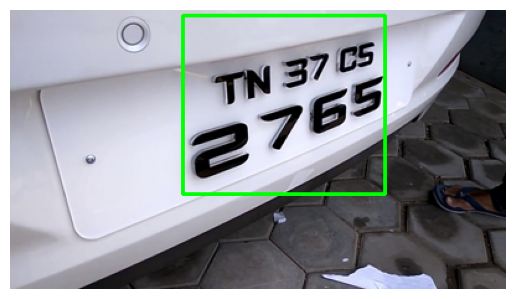

In [21]:
import os
import cv2
import matplotlib.pyplot as plt

image_dir = 'datasets/cars_license_plate_new/train/images'
label_dir = 'datasets/cars_license_plate_new/train/labels'

image_files = sorted(os.listdir(image_dir))
first_image_file = image_files[1]

image_path = os.path.join(image_dir, first_image_file)
label_path = os.path.join(label_dir, os.path.splitext(first_image_file)[0] + '.txt')

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

with open(label_path, 'r') as f:
    lines = f.readlines()

for line in lines:
    class_id, x_center, y_center, width, height = map(float, line.strip().split())
    img_height, img_width, _ = image.shape

    x_center *= img_width
    y_center *= img_height
    width *= img_width
    height *= img_height

    x1 = int(x_center - width / 2)
    y1 = int(y_center - height / 2)
    x2 = int(x_center + width / 2)
    y2 = int(y_center + height / 2)

    cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)

plt.imshow(image)
plt.axis('off')
plt.show()

In [22]:
datasets_yaml = '''
path: cars_license_plate_new

train: train/images
val: val/images
test: test/images

# number of classes
nc: 1

# class names
names: ['license_plate']
'''

with open('datasets.yaml', 'w') as file:
    file.write(datasets_yaml)

In [23]:
from ultralytics import YOLO
model = YOLO('yolov9s.pt')

In [54]:
model.train(
    data='datasets.yaml',  # Path to the dataset configuration file
    epochs=100,            # Number of training epochs
    batch=16,              # Batch size
    imgsz=320,             # Image size (width and height) for training
    cache=True             # Cache images for faster training
)

Ultralytics YOLOv8.2.48  Python-3.12.4 torch-2.3.1+cpu CPU (Intel Core(TM) i7-8700K 3.70GHz)
engine\trainer: task=detect, mode=train, model=yolov9s.pt, data=datasets.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=320, save=True, save_period=-1, cache=True, device=None, workers=8, project=None, name=train3, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=

train: Scanning C:\Users\nikod\PycharmProjects\carPlateDetector\datasets\cars_license_plate_new\train\labels.cache... 345 images, 0 backgrounds, 0 corrupt: 100%|██████████| 345/345 [00:00<?, ?it/s]
train: Caching images (0.1GB RAM): 100%|██████████| 345/345 [00:00<00:00, 831.17it/s]
val: Scanning C:\Users\nikod\PycharmProjects\carPlateDetector\datasets\cars_license_plate_new\val\labels.cache... 44 images, 0 backgrounds, 0 corrupt: 100%|██████████| 44/44 [00:00<?, ?it/s]
val: Caching images (0.0GB RAM): 100%|██████████| 44/44 [00:00<00:00, 759.32it/s]


Plotting labels to runs\detect\train3\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 221 weight(decay=0.0), 228 weight(decay=0.0005), 227 bias(decay=0.0)
Image sizes 320 train, 320 val
Using 0 dataloader workers
Logging results to runs\detect\train3
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100         0G      1.657      2.055       1.33         17        320: 100%|██████████| 22/22 [02:45<00:00,  7.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.34s/it]

                   all         44         44      0.599      0.682      0.508      0.228



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100         0G      1.388      1.186      1.198         17        320: 100%|██████████| 22/22 [02:45<00:00,  7.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.13s/it]

                   all         44         44      0.266      0.682      0.234      0.108



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100         0G      1.525      1.105       1.27         13        320: 100%|██████████| 22/22 [02:36<00:00,  7.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.13s/it]

                   all         44         44      0.713      0.622      0.641      0.295



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100         0G      1.578       1.02      1.321         19        320: 100%|██████████| 22/22 [02:36<00:00,  7.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.24s/it]

                   all         44         44      0.451      0.682      0.412      0.168



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100         0G      1.583      1.044      1.316         14        320: 100%|██████████| 22/22 [02:35<00:00,  7.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.11s/it]

                   all         44         44      0.715       0.75      0.741      0.357



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100         0G      1.548      1.054       1.31         20        320: 100%|██████████| 22/22 [02:40<00:00,  7.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.11s/it]

                   all         44         44      0.644      0.822       0.79      0.315



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100         0G      1.573      1.008      1.346         13        320: 100%|██████████| 22/22 [02:36<00:00,  7.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.12s/it]

                   all         44         44      0.697       0.75      0.709      0.335



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100         0G      1.481     0.9884      1.335         24        320: 100%|██████████| 22/22 [02:36<00:00,  7.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.10s/it]

                   all         44         44      0.721      0.765      0.775      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100         0G      1.405     0.8575      1.274         11        320: 100%|██████████| 22/22 [02:35<00:00,  7.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.13s/it]

                   all         44         44       0.81      0.705      0.791      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100         0G      1.418     0.8824      1.258         16        320: 100%|██████████| 22/22 [02:34<00:00,  7.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.06s/it]

                   all         44         44      0.692      0.819       0.78      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100         0G      1.398     0.8691      1.252         23        320: 100%|██████████| 22/22 [02:33<00:00,  6.99s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.06s/it]

                   all         44         44      0.716      0.802      0.785      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100         0G       1.39     0.8192      1.196         21        320: 100%|██████████| 22/22 [02:34<00:00,  7.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.05s/it]

                   all         44         44       0.81      0.874      0.858       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100         0G      1.322     0.8137      1.198         21        320: 100%|██████████| 22/22 [02:33<00:00,  6.97s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.06s/it]

                   all         44         44       0.91      0.795       0.89      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100         0G      1.339     0.8347      1.205         14        320: 100%|██████████| 22/22 [02:33<00:00,  6.99s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.05s/it]

                   all         44         44      0.868      0.864      0.882      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100         0G      1.342     0.8091      1.219         13        320: 100%|██████████| 22/22 [02:33<00:00,  6.98s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.05s/it]

                   all         44         44      0.792       0.75      0.857      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100         0G      1.348     0.8576      1.232         15        320: 100%|██████████| 22/22 [02:33<00:00,  6.99s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.07s/it]

                   all         44         44      0.721      0.864      0.829      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100         0G      1.321     0.7769      1.177         15        320: 100%|██████████| 22/22 [02:33<00:00,  6.97s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.06s/it]

                   all         44         44      0.788      0.841      0.821      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100         0G      1.333     0.7986      1.225         13        320: 100%|██████████| 22/22 [02:33<00:00,  7.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.03s/it]

                   all         44         44      0.866      0.795      0.858      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100         0G      1.304     0.7466      1.172         14        320: 100%|██████████| 22/22 [02:32<00:00,  6.94s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.06s/it]

                   all         44         44      0.786      0.841      0.882      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100         0G      1.306     0.7336      1.149         13        320: 100%|██████████| 22/22 [02:32<00:00,  6.95s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.05s/it]

                   all         44         44      0.912      0.818      0.876      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100         0G      1.289     0.7179      1.169         22        320: 100%|██████████| 22/22 [02:34<00:00,  7.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.04s/it]

                   all         44         44      0.898      0.841      0.875      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100         0G      1.248      0.739      1.184         13        320: 100%|██████████| 22/22 [02:33<00:00,  6.98s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.04s/it]

                   all         44         44      0.755      0.932      0.878      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100         0G      1.238     0.7192      1.146         24        320: 100%|██████████| 22/22 [02:32<00:00,  6.95s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.06s/it]

                   all         44         44      0.837      0.864       0.92       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100         0G      1.198     0.7132      1.136         19        320: 100%|██████████| 22/22 [02:33<00:00,  6.95s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.02s/it]

                   all         44         44      0.925      0.795      0.865      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100         0G      1.236     0.7029      1.155         19        320: 100%|██████████| 22/22 [02:36<00:00,  7.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.09s/it]

                   all         44         44      0.803      0.833      0.837       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100         0G      1.175      0.691      1.102         20        320: 100%|██████████| 22/22 [02:34<00:00,  7.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.09s/it]

                   all         44         44      0.836      0.864      0.883       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100         0G      1.131     0.6855       1.14         14        320: 100%|██████████| 22/22 [02:34<00:00,  7.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.08s/it]

                   all         44         44       0.88      0.841       0.87      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100         0G      1.151     0.6472      1.147         18        320: 100%|██████████| 22/22 [02:35<00:00,  7.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.08s/it]

                   all         44         44      0.882      0.818      0.871        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100         0G      1.206     0.6604      1.125         23        320: 100%|██████████| 22/22 [02:35<00:00,  7.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.07s/it]

                   all         44         44      0.852      0.909      0.896      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100         0G      1.164     0.6595      1.143         15        320: 100%|██████████| 22/22 [02:33<00:00,  7.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.12s/it]

                   all         44         44      0.891      0.818       0.87      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100         0G      1.156     0.6499      1.131         17        320: 100%|██████████| 22/22 [02:31<00:00,  6.91s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.03s/it]

                   all         44         44      0.874      0.886      0.897      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100         0G      1.156     0.6422       1.12         15        320: 100%|██████████| 22/22 [02:32<00:00,  6.93s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.02s/it]

                   all         44         44      0.828      0.909      0.868      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100         0G      1.063      0.617      1.083         19        320: 100%|██████████| 22/22 [02:32<00:00,  6.95s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.03s/it]

                   all         44         44      0.799      0.886      0.883      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100         0G      1.094     0.6278      1.115         19        320: 100%|██████████| 22/22 [02:33<00:00,  6.97s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.03s/it]

                   all         44         44      0.872      0.773      0.882      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100         0G      1.083      0.628      1.077         16        320: 100%|██████████| 22/22 [02:32<00:00,  6.91s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.01s/it]

                   all         44         44      0.809      0.869       0.92      0.542



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100         0G       1.07     0.6473      1.096         14        320: 100%|██████████| 22/22 [02:32<00:00,  6.94s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.05s/it]

                   all         44         44      0.926       0.85      0.907      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100         0G      1.107     0.6358      1.116         20        320: 100%|██████████| 22/22 [02:33<00:00,  6.97s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.04s/it]

                   all         44         44       0.85      0.902      0.894      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100         0G      1.065     0.6201      1.097         17        320: 100%|██████████| 22/22 [02:32<00:00,  6.95s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.02s/it]

                   all         44         44      0.861      0.847      0.909      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100         0G      1.071     0.5934      1.081         16        320: 100%|██████████| 22/22 [02:33<00:00,  6.96s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.04s/it]

                   all         44         44      0.849      0.886      0.899      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100         0G      1.028     0.5834      1.061         16        320: 100%|██████████| 22/22 [02:32<00:00,  6.94s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.02s/it]

                   all         44         44      0.904      0.864      0.899      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100         0G      1.034     0.5828      1.053         16        320: 100%|██████████| 22/22 [02:32<00:00,  6.94s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.01s/it]

                   all         44         44      0.926      0.849      0.909      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100         0G      1.001     0.5676      1.056         22        320: 100%|██████████| 22/22 [02:32<00:00,  6.93s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.03s/it]

                   all         44         44      0.885      0.955      0.941      0.549



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100         0G     0.9966     0.5766      1.072         16        320: 100%|██████████| 22/22 [02:32<00:00,  6.95s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.03s/it]

                   all         44         44      0.883      0.862       0.88      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100         0G      0.995     0.5383      1.057         14        320: 100%|██████████| 22/22 [02:32<00:00,  6.95s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.02s/it]

                   all         44         44      0.812      0.882      0.856      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100         0G      1.031     0.5531      1.039         14        320: 100%|██████████| 22/22 [02:32<00:00,  6.93s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.03s/it]

                   all         44         44      0.881      0.909      0.913      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100         0G     0.9562     0.5429      1.029         20        320: 100%|██████████| 22/22 [02:32<00:00,  6.92s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.01s/it]

                   all         44         44      0.949      0.773       0.88      0.545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100         0G     0.9561     0.5455      1.037         14        320: 100%|██████████| 22/22 [02:32<00:00,  6.92s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.04s/it]

                   all         44         44      0.882      0.848      0.885      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100         0G          1     0.5486      1.042         17        320: 100%|██████████| 22/22 [02:31<00:00,  6.90s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.01s/it]

                   all         44         44      0.845      0.869      0.883      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100         0G     0.9381     0.5164      1.056         20        320: 100%|██████████| 22/22 [02:32<00:00,  6.93s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.02s/it]

                   all         44         44      0.857      0.841      0.883      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100         0G     0.9785     0.5565      1.051         17        320: 100%|██████████| 22/22 [02:32<00:00,  6.95s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.10s/it]

                   all         44         44      0.884      0.863      0.896      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100         0G     0.9699      0.528      1.032         16        320: 100%|██████████| 22/22 [02:32<00:00,  6.92s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.03s/it]

                   all         44         44      0.905      0.862      0.911      0.546



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100         0G     0.9315     0.5095      1.005         14        320: 100%|██████████| 22/22 [02:32<00:00,  6.92s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.04s/it]

                   all         44         44      0.822      0.886      0.894      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100         0G     0.8979     0.5078      0.988         13        320: 100%|██████████| 22/22 [02:32<00:00,  6.91s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.04s/it]

                   all         44         44      0.825      0.886      0.906      0.545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100         0G     0.8879     0.4999      1.016         16        320: 100%|██████████| 22/22 [02:32<00:00,  6.94s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.02s/it]

                   all         44         44      0.858      0.864      0.884      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100         0G     0.9121     0.4967      1.015         15        320: 100%|██████████| 22/22 [02:32<00:00,  6.94s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.04s/it]

                   all         44         44      0.895      0.818      0.901      0.532



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100         0G     0.9352     0.5021      1.023         16        320: 100%|██████████| 22/22 [02:31<00:00,  6.90s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.02s/it]

                   all         44         44      0.951      0.841      0.916       0.55



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100         0G     0.9183     0.5127       1.02         21        320: 100%|██████████| 22/22 [02:31<00:00,  6.91s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.03s/it]

                   all         44         44      0.828      0.877      0.905      0.535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100         0G     0.8757     0.4981     0.9873         19        320: 100%|██████████| 22/22 [02:32<00:00,  6.94s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.03s/it]

                   all         44         44      0.803      0.926      0.889      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100         0G     0.9061     0.5148     0.9994         16        320: 100%|██████████| 22/22 [02:32<00:00,  6.94s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.03s/it]

                   all         44         44      0.821      0.864       0.88      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100         0G     0.8771     0.4861      1.004          9        320: 100%|██████████| 22/22 [02:31<00:00,  6.91s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.02s/it]

                   all         44         44      0.861      0.864      0.917      0.538



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100         0G     0.8506     0.4747     0.9818         17        320: 100%|██████████| 22/22 [02:32<00:00,  6.92s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.03s/it]

                   all         44         44      0.862      0.853      0.896       0.53



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100         0G     0.8479     0.4751     0.9958         15        320: 100%|██████████| 22/22 [02:34<00:00,  7.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.08s/it]

                   all         44         44      0.847      0.886      0.893      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100         0G     0.8594     0.4778     0.9779         18        320: 100%|██████████| 22/22 [02:35<00:00,  7.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.46s/it]

                   all         44         44      0.831      0.909      0.897      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100         0G     0.8638     0.4776     0.9854         14        320: 100%|██████████| 22/22 [02:35<00:00,  7.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.09s/it]

                   all         44         44       0.84      0.886      0.876      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100         0G     0.8479     0.4641      1.011         15        320: 100%|██████████| 22/22 [02:35<00:00,  7.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.10s/it]

                   all         44         44      0.768      0.932      0.892      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100         0G     0.7953     0.4466     0.9909         16        320: 100%|██████████| 22/22 [02:34<00:00,  7.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.09s/it]

                   all         44         44      0.822      0.839      0.878      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100         0G     0.8108     0.4668     0.9832         13        320: 100%|██████████| 22/22 [02:34<00:00,  7.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.07s/it]

                   all         44         44       0.86      0.836      0.887      0.527



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100         0G     0.8184     0.4669     0.9868         16        320: 100%|██████████| 22/22 [02:34<00:00,  7.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.06s/it]

                   all         44         44      0.798      0.909      0.866      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100         0G     0.8349     0.4843      1.005         15        320: 100%|██████████| 22/22 [02:34<00:00,  7.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.07s/it]

                   all         44         44      0.826      0.886      0.896      0.532



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100         0G     0.8102     0.4628     0.9856         13        320: 100%|██████████| 22/22 [02:34<00:00,  7.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.11s/it]

                   all         44         44      0.846      0.864      0.868       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100         0G      0.791     0.4542     0.9782         16        320: 100%|██████████| 22/22 [02:34<00:00,  7.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.03s/it]

                   all         44         44       0.85      0.909      0.899      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100         0G     0.8198     0.4416     0.9871         13        320: 100%|██████████| 22/22 [02:31<00:00,  6.91s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.03s/it]

                   all         44         44      0.799      0.904        0.9      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100         0G     0.8103     0.4585      0.975         16        320: 100%|██████████| 22/22 [02:32<00:00,  6.95s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.04s/it]

                   all         44         44      0.803      0.909      0.891      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100         0G     0.7654     0.4407     0.9618         15        320: 100%|██████████| 22/22 [02:31<00:00,  6.91s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.10s/it]

                   all         44         44      0.812      0.886       0.88      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100         0G     0.7448       0.43     0.9479         18        320: 100%|██████████| 22/22 [02:32<00:00,  6.92s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.23s/it]

                   all         44         44      0.828      0.878      0.903      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100         0G     0.7412      0.424     0.9725         12        320: 100%|██████████| 22/22 [02:34<00:00,  7.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.06s/it]

                   all         44         44      0.806      0.886      0.906      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100         0G     0.7492     0.4303     0.9656         21        320: 100%|██████████| 22/22 [02:34<00:00,  7.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.07s/it]

                   all         44         44      0.806      0.886      0.906      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100         0G     0.7307     0.4051     0.9401         14        320: 100%|██████████| 22/22 [02:35<00:00,  7.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.08s/it]

                   all         44         44      0.852      0.841      0.875       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100         0G     0.7684      0.418      0.984         15        320: 100%|██████████| 22/22 [02:34<00:00,  7.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.09s/it]

                   all         44         44      0.849      0.841      0.864      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100         0G     0.7452     0.4025     0.9562         16        320: 100%|██████████| 22/22 [02:35<00:00,  7.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.09s/it]

                   all         44         44      0.805      0.886      0.893      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100         0G     0.7126     0.4033     0.9587         17        320: 100%|██████████| 22/22 [02:36<00:00,  7.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.12s/it]

                   all         44         44      0.833      0.841      0.883      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100         0G     0.7321     0.3999     0.9528         13        320: 100%|██████████| 22/22 [02:33<00:00,  7.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.02s/it]

                   all         44         44       0.84      0.835      0.883      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100         0G     0.7195     0.3987     0.9329         19        320: 100%|██████████| 22/22 [02:32<00:00,  6.93s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.03s/it]

                   all         44         44       0.84      0.834       0.87      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100         0G     0.7221     0.4032     0.9468         23        320: 100%|██████████| 22/22 [02:32<00:00,  6.93s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.03s/it]

                   all         44         44      0.799      0.903      0.883      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100         0G     0.7202     0.4074     0.9401         16        320: 100%|██████████| 22/22 [02:32<00:00,  6.91s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.02s/it]

                   all         44         44      0.812      0.885      0.884       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100         0G     0.7142     0.4015      0.953         18        320: 100%|██████████| 22/22 [02:32<00:00,  6.94s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.03s/it]

                   all         44         44      0.856      0.809      0.869      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100         0G     0.7015      0.399      0.978         17        320: 100%|██████████| 22/22 [02:32<00:00,  6.93s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.04s/it]

                   all         44         44      0.881      0.838      0.882      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100         0G     0.6724     0.3865     0.9614         13        320: 100%|██████████| 22/22 [02:32<00:00,  6.92s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.03s/it]

                   all         44         44      0.854      0.841       0.87      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100         0G      0.657     0.3783     0.9205         18        320: 100%|██████████| 22/22 [02:32<00:00,  6.92s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.04s/it]

                   all         44         44      0.821      0.818      0.882       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100         0G     0.6732     0.3709     0.9285         17        320: 100%|██████████| 22/22 [02:32<00:00,  6.93s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.02s/it]

                   all         44         44      0.835      0.841      0.878      0.499


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100         0G     0.9757     0.4745      1.071          9        320: 100%|██████████| 22/22 [02:32<00:00,  6.94s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.05s/it]

                   all         44         44      0.873      0.841      0.881      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100         0G     0.9249     0.4507      1.091          9        320: 100%|██████████| 22/22 [02:32<00:00,  6.92s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.02s/it]

                   all         44         44      0.901      0.841      0.903      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100         0G     0.9458     0.4491      1.046          9        320: 100%|██████████| 22/22 [02:32<00:00,  6.93s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.04s/it]

                   all         44         44      0.858      0.841      0.894      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100         0G     0.9275     0.4381      1.043          9        320: 100%|██████████| 22/22 [02:31<00:00,  6.90s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.03s/it]

                   all         44         44       0.85      0.841      0.875      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100         0G     0.9252     0.4364      1.061          9        320: 100%|██████████| 22/22 [02:31<00:00,  6.89s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.03s/it]

                   all         44         44      0.835      0.841      0.872      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100         0G     0.9376     0.4329      1.036          9        320: 100%|██████████| 22/22 [02:31<00:00,  6.90s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.03s/it]

                   all         44         44      0.839      0.841        0.9      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100         0G      0.913     0.4242      1.033          9        320: 100%|██████████| 22/22 [02:31<00:00,  6.89s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.05s/it]

                   all         44         44      0.876      0.801      0.903      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100         0G     0.8862     0.4264       1.03          9        320: 100%|██████████| 22/22 [02:31<00:00,  6.90s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.03s/it]

                   all         44         44      0.869      0.841        0.9      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100         0G     0.8694     0.4094      1.034          9        320: 100%|██████████| 22/22 [02:31<00:00,  6.89s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.03s/it]

                   all         44         44      0.869      0.841      0.882      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100         0G     0.8968      0.426      1.016          9        320: 100%|██████████| 22/22 [02:32<00:00,  6.91s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.11s/it]

                   all         44         44      0.869      0.841      0.901      0.521



100 epochs completed in 4.461 hours.
Optimizer stripped from runs\detect\train3\weights\last.pt, 15.2MB
Optimizer stripped from runs\detect\train3\weights\best.pt, 15.2MB

Validating runs\detect\train3\weights\best.pt...
Ultralytics YOLOv8.2.48  Python-3.12.4 torch-2.3.1+cpu CPU (Intel Core(TM) i7-8700K 3.70GHz)
YOLOv9s summary (fused): 486 layers, 7167475 parameters, 0 gradients, 26.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:05<00:00,  2.81s/it]


                   all         44         44      0.886      0.955      0.941      0.549
Speed: 0.6ms preprocess, 125.3ms inference, 0.0ms loss, 0.2ms postprocess per image
Results saved to runs\detect\train3


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x0000023FB5FDADB0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.0480

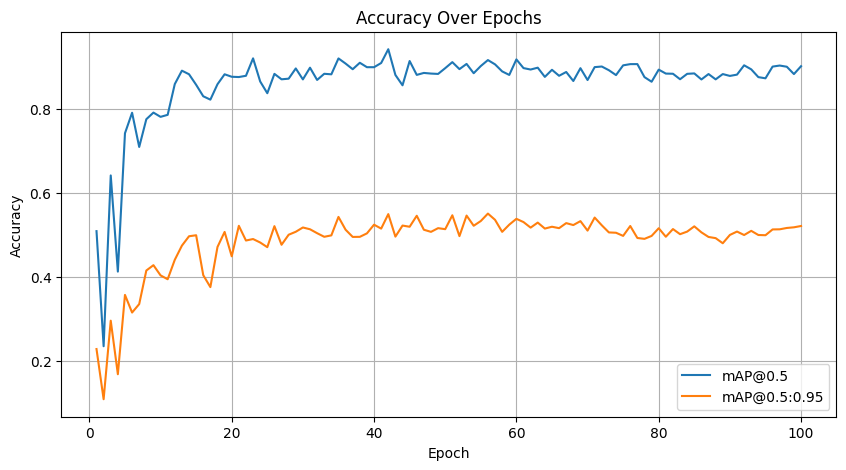

In [24]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob


log_dir = max(glob('runs/detect/train*'), key=the_number_in_the_string)

results = pd.read_csv(os.path.join(log_dir, 'results.csv'))
results.columns = results.columns.str.strip()  # Remove any leading/trailing whitespace from column names

epochs = results.index + 1
mAP_0_5 = results['metrics/mAP50(B)']
mAP_0_5_0_95 = results['metrics/mAP50-95(B)']  # Mean Average Precision at IoU=0.5:0.95

plt.figure(figsize=(10, 5))
plt.plot(epochs, mAP_0_5, label='mAP@0.5')
plt.plot(epochs, mAP_0_5_0_95, label='mAP@0.5:0.95')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [8]:
model.save('best_license_plate_model.pt')

NameError: name 'model' is not defined

In [25]:
import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO


def predict_and_plot(path_test_car):
    results = model.predict(path_test_car, device='cpu')

    image = cv2.imread(path_test_car)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    for result in results:
        for box in result.boxes:
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            confidence = box.conf[0]

            cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(image, f'{confidence*100:.2f}%', (x1, y1 - 10), 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)

    plt.imshow(image)
    plt.axis('off')
    plt.show()

image 1/1 C:\Users\nikod\PycharmProjects\carPlateDetector\datasets\cars_license_plate_new\test\images\Cars323.png: 384x640 1 car, 346.1ms
Speed: 2.0ms preprocess, 346.1ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)
Detected text: N . A
—
w TNSSF 2378 &
———=
SS eee


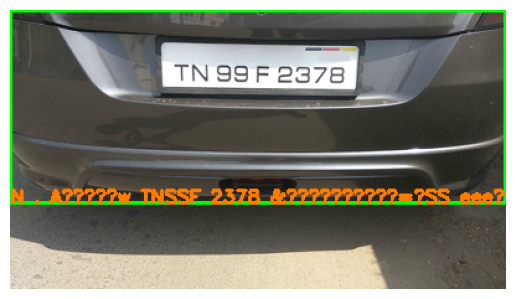

In [52]:
predict_and_plot('datasets/cars_license_plate_new/test/images/Cars323.png')

In [37]:
import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO
import pytesseract
from pytesseract import Output


def predict_and_plot(path_test_car):

    results = model.predict(path_test_car, device='cpu')

    image = cv2.imread(path_test_car)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    for result in results:
        for box in result.boxes:
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            confidence = box.conf[0]

            cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(image, f'{confidence*100:.2f}%', (x1, y1 - 10), 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

            roi = gray_image[y1:y2, x1:x2]

            text = pytesseract.image_to_string(roi,lang='eng', config = r'--oem 3 --psm 6')
            cv2.putText(image, f'{text}', (x1, y1 + y2), 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 123, 0), 2)
            print(f"Detected text: {text}")

    plt.imshow(image)
    plt.axis('off')
    plt.show()

In [50]:
predict_and_plot('datasets/cars_license_plate_new/test/images/Cars329.png')

FileNotFoundError: datasets/cars_license_plate_new/test/images/Cars329.png does not exist